In [1]:
# Imports

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.optimizers import Adam
import scipy
import pickle
from keras import backend as K
%matplotlib inline

np.random.seed(42)

Using TensorFlow backend.


# Analyzing data

## 1. Loading the data
This dataset is in json format. The following load_json function loads the whole dataset into a list in Python.

In [2]:
# Loading the data (it's preloaded in Keras)
def load_json(path='./data/train.json'):
    with open(path) as json_data:
        dta = json.load(json_data)
        json_data.close()
    return dta
dta =load_json(path='./data/train.json')

In [3]:
print('There are {} images in this dataset.'.format(len(dta)))
keys = list(dta[0].keys())
print('Each sample is a dictionary with {} keys.'.format(keys))
band_1 = dta[0]['band_1']
band_2 = dta[0]['band_2']
if len(band_1) == len(band_2):
    print('The lengths of band_1 and band_2 are the same and are equal with {}.'.format(len(band_1)))
    
is_iceberg = np.unique([dta[i]['is_iceberg'] for i in range(len(dta))])
print('The is_iceberg has the values of {}.'.format(is_iceberg))

There are 1604 images in this dataset.
Each sample is a dictionary with ['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'] keys.
The lengths of band_1 and band_2 are the same and are equal with 5625.
The is_iceberg has the values of [0 1].


To further study the characteristics of the data, histograms of band_1 and band_2 are plotted as follows:

In [4]:
def flatten_data(json_data=dta):
    ##
    samples_len = len(json_data)
    model_target = []
    sample = []
    band_1 = []
    band_2 = []
    inc_angle = []
    ##
    for sample_n in range(samples_len):
        #
        model_target_temp = [json_data[sample_n]['is_iceberg']]*len(json_data[sample_n]['band_1'])
        model_target.extend(model_target_temp)
        ##
        sample_temp = [sample_n]*len(json_data[sample_n]['band_1'])
        sample.extend(sample_temp)
        ##
        inc_angle_temp = [json_data[sample_n]['inc_angle']]*len(json_data[sample_n]['band_1'])
        inc_angle.extend(inc_angle_temp)
        ##
        band_1 += json_data[sample_n]['band_1']
        band_2 += json_data[sample_n]['band_2']
        ##
    ##
    return band_1, band_2, inc_angle, model_target, sample
band_1, band_2, inc_angle, model_target, sample = flatten_data(json_data=dta)

In [5]:
## converting data to a pandas dataframe
dc = {'band_1':band_1, 'band_2':band_2, 'inc_angle':inc_angle, 'target':model_target, 'sample':sample}
df = pd.DataFrame(dc)
df.head(4)

,band_1,band_2,inc_angle,sample,target
0,-27.878361,-27.154118,43.9239,0,0
1,-27.154160,-29.537888,43.9239,0,0
2,-28.668615,-31.030600,43.9239,0,0
3,-29.537971,-32.190483,43.9239,0,0


## 2. Exploring the data

In [6]:
df_2 = pd.DataFrame()
df_2['target'] = df.groupby('sample')['sample', 'target'].apply(lambda x: np.unique(x.target)[0])
df_2.reset_index(drop=False, inplace=True)

**The following barchart shows the counts of images with (1) and without (0) iceberg.**

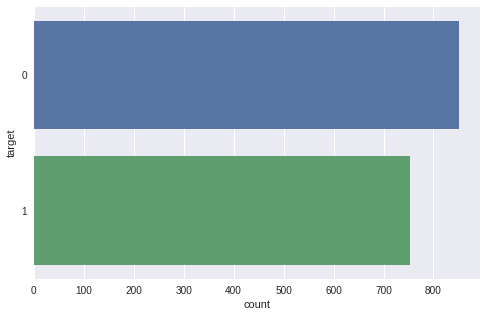

In [7]:
fig = plt.figure(figsize=(8,5))
sns.countplot(y="target", data=df_2)
plt.show()

**The following histograms show the distribution of band_1, band_2, and inc_angle values.**

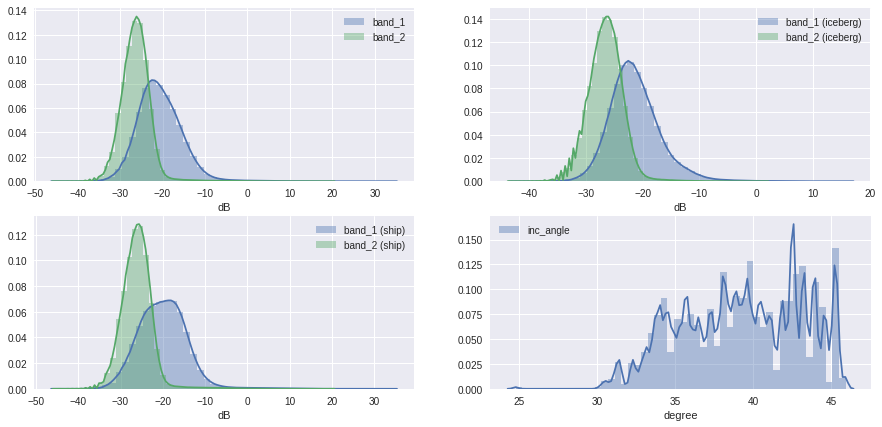

In [8]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(2, 2, 1)
sns.distplot(df.band_1, label='band_1')
sns.distplot(df.band_2, label='band_2')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 2)
sns.distplot(df[df.target==1]['band_1'], label='band_1 (iceberg)')
sns.distplot(df[df.target==1]['band_2'], label='band_2 (iceberg)')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 3)
sns.distplot(df[df.target==0]['band_1'], label='band_1 (ship)')
sns.distplot(df[df.target==0]['band_2'], label='band_2 (ship)')
plt.legend()
plt.xlabel('dB')

ax = fig.add_subplot(2, 2, 4)
sns.distplot(df[df.inc_angle!='na']['inc_angle'], label='inc_angle')
plt.legend()
plt.xlabel('degree')

plt.show()

## 3. Preparing the data

In the next step, the values of band_1 and band_2 are used to construct images with three channels that can be used to train a benchmark model and also to extract bottleneck features using VGG-16 and ResNet-50 architectures. The is_iceberg values are the models target (y) with values of 1 and 0 corresponding to images with iceberg and without iceberg respectively. Here a function is created that does the data conversion task.

In [9]:
def convert_data(json_data=dta):
    ##
    samples_len = len(json_data)
    width = int(np.sqrt(len(json_data[0]['band_1'])))
    height = width
    ##
    model_input = np.zeros(shape=(samples_len, width, height, 3))
    model_target = np.zeros(shape=(samples_len, 1))
    ##
    for sample_n in range(samples_len):
        ##
        band_1 = np.array(json_data[sample_n]['band_1'])
        band_1 += abs(min(band_1))
        band_1 *= 255/max(band_1)
        #
        band_2 = np.array(json_data[sample_n]['band_2'])
        band_2 += abs(min(band_2))
        band_2 *= 255/max(band_2)
        ##
        image = list(band_1) + list(band_2) + list(band_2)
        image_reshaped = np.reshape(image, [width, height, 3])
        ##
        model_input[sample_n] = image_reshaped
        ##
        model_target[sample_n] = json_data[sample_n]['is_iceberg']
    ##
    return model_input, model_target

In [10]:
model_input, model_target = convert_data(json_data=dta)

In [11]:
model_input.shape

(1604, 75, 75, 3)

## 4. Splitting data into train and validation sets
Here, the model_input dataset is divided into train and validation sets.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(model_input, model_target, test_size=0.20, random_state=19)

In [13]:
X_train.shape

(1283, 75, 75, 3)

## 5. Building the benchmark  model architecture
Here, the benchmark CNN model architecture is constructed.

In [14]:
def construct_benchmark(inp):
    ##
    K.clear_session()
    ##
    np.random.seed(42)
    ##
    model = Sequential()
    ##
    model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu',
                     input_shape=inp.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:

benchmark = construct_benchmark(inp=X_train)
benchmark.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

In [16]:

adam = Adam(lr=0.00015)
benchmark.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

##
checkpointer = ModelCheckpoint(filepath='./weights/benchmark_weights.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

hist_1 = benchmark.fit(X_train, y_train,
                     batch_size=32,
                     validation_data=(X_val, y_val),
                     epochs=200,
                     callbacks=[checkpointer],
                     verbose=0)

Epoch 00000: val_acc improved from -inf to 0.53271, saving model to ./weights/benchmark_weights.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.53271 to 0.62617, saving model to ./weights/benchmark_weights.hdf5
Epoch 00003: val_acc improved from 0.62617 to 0.66355, saving model to ./weights/benchmark_weights.hdf5
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc improved from 0.66355 to 0.68536, saving model to ./weights/benchmark_weights.hdf5
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc improved from 0.68536 to 0.71963, saving model to ./weights/benchmark_weights.hdf5
Epoch 00012: val_acc improved from 0.71963 to 0.72897, saving model to ./weights/benchmark_weights.hdf5
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc improved from 0.72897 to 0.73209, saving model to ./weights/be

Epoch 00191: val_acc did not improve
Epoch 00192: val_acc did not improve
Epoch 00193: val_acc did not improve
Epoch 00194: val_acc did not improve
Epoch 00195: val_acc did not improve
Epoch 00196: val_acc did not improve
Epoch 00197: val_acc did not improve
Epoch 00198: val_acc did not improve
Epoch 00199: val_acc did not improve


** The following function is used for plotting the score variations of the train and validation datasets over epochs.**

In [17]:
def plot_history(hist, title=''):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    return

**The following figure shows how the train and vlidation accuracy scores change by epoch.**

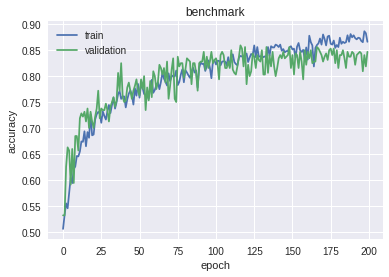

In [18]:
plot_history(hist=hist_1, title='benchmark')

In [19]:
model = construct_benchmark(inp=X_train)
model.load_weights('./weights/benchmark_weights.hdf5')
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
benchmark_score = model.evaluate(X_val, y_val, verbose=0)
print("The {} accuracy is: {:.3f}".format('benchmark', benchmark_score[1]))

acc = {}
acc['benchmark'] = benchmark_score


The benchmark accuracy is: 0.860


## 6. Adding layers to the benchmark model

**In the next steps, more layers are added to the benchmark model.**

In [20]:
def construct_model(inp=X_train):
    ##
    K.clear_session()
    ##
    model = Sequential()
    ##
    model.add(Conv2D(filters=16, kernel_size=2, strides=1, padding='same', activation='relu',
                     input_shape=inp.shape[1:]))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=220, kernel_size=2, strides=1, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [21]:
model_1 = construct_model(inp=X_train)
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 75, 16)        208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 220)         56540     
__________

In [22]:
adam = Adam(lr=0.00015)
model_1.compile(loss='binary_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])

##
checkpointer = ModelCheckpoint(filepath='./weights/model_1_weights.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

hist_2 = model_1.fit(X_train, y_train, 
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   epochs=200,
                   callbacks=[checkpointer], 
                   verbose=0)

Epoch 00000: val_acc improved from -inf to 0.71028, saving model to ./weights/model_1_weights.hdf5
Epoch 00001: val_acc did not improve
Epoch 00002: val_acc improved from 0.71028 to 0.73209, saving model to ./weights/model_1_weights.hdf5
Epoch 00003: val_acc did not improve
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc did not improve
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc improved from 0.73209 to 0.75078, saving model to ./weights/model_1_weights.hdf5
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc did not improve
Epoch 00010: val_acc improved from 0.75078 to 0.76324, saving model to ./weights/model_1_weights.hdf5
Epoch 00011: val_acc improved from 0.76324 to 0.76947, saving model to ./weights/model_1_weights.hdf5
Epoch 00012: val_acc did not improve
Epoch 00013: val_acc did not improve
Epoch 00014: val_acc did not improve
Epoch 00015: val_acc did not improve
Epoch 00016: val_acc did not improve
Epoch 00017: val_acc did not improve
Epoch 00018:

Epoch 00196: val_acc did not improve
Epoch 00197: val_acc did not improve
Epoch 00198: val_acc did not improve
Epoch 00199: val_acc did not improve


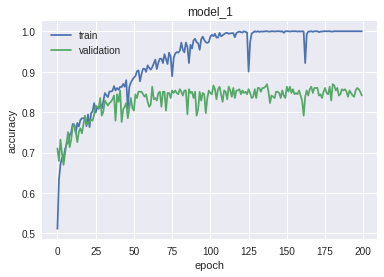

In [23]:
plot_history(hist=hist_2, title='model_1')

In [24]:
model = construct_model(inp=X_train)
model.load_weights('./weights/model_1_weights.hdf5')
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
model_1_score = model.evaluate(X_val, y_val, verbose=0)
print("The {} accuracy is: {:.3f}".format('model_1', model_1_score[1]))

acc['model_1'] = model_1_score


The model_1 accuracy is: 0.869


## 7. Extracting bottleneck features
**In the following steps, the ResNet50 bottleneck features are extracted and used for the prediction.**

**First, the following function is used to extract and save the ResNet50 bottleneck features.**

In [25]:
from extract_bottleneck_features import *

def extract_ResNet50_features(json_data=dta):
    ##
    samples_len = len(json_data)
    width = int(np.sqrt(len(json_data[0]['band_1'])))
    height = width
    ##
    model_input = np.zeros(shape=(samples_len, 2, 2, 2048))
    model_target = np.zeros(shape=(samples_len, 1))
    ##
    n=0
    for sample_n in range(samples_len):
        ##
        n += 1
        
        ##
        band_1 = json_data[sample_n]['band_1']
        band_1 = np.array(band_1)
        band_1 = band_1 + abs(min(band_1))
        band_1 = band_1*255/max(band_1)
        
        ##
        band_2 = json_data[sample_n]['band_2']
        band_2 = np.array(band_2)
        band_2 = band_2 + abs(min(band_2))
        band_2 = band_2*255/max(band_2)
        
        ##
        image = list(band_1) + list(band_2) + list(band_2)
        
        ##
        image_reshaped = np.reshape(image, [width, height, 3])
        ## to resize the image so it can be fed into Resnet50 model
        image_reshaped = scipy.misc.imresize(image_reshaped, (256, 256, 3))
        image_reshaped = image_reshaped.astype('float32')

        ## too clear the session and free the memory
        if n>10:
            K.clear_session()
            n = 0
        ##
        bottleneck_feature = extract_Resnet50(np.expand_dims(image_reshaped, axis=0))
        
        ##
        model_input[sample_n] = bottleneck_feature
        
        ##
        model_target[sample_n] = json_data[sample_n]['is_iceberg']
    ##
    return model_input, model_target

** The following block can be used to extract and save the bottleneck features.**

In [26]:
# uncomment the following lines to extract and save bottleneck features

# from extract_bottleneck_features import *
# model_input, model_target = extract_ResNet50_features(json_data=dta)

##
# features = {}
# features['features'] = model_input
# features['target'] = model_target

# with open('./bottleneck_features/ResNet50_features.pkl', 'wb') as handle:
#     pickle.dump(features, handle)

** The following function is used to load the bottleneck features.** 

In [27]:
def load_bottleneckFeatures(path):
    with (open(path, "rb")) as openfile:
        features = pickle.load(openfile)
    return features

In [28]:
bottleneckFeatures = load_bottleneckFeatures(path='./bottleneck_features/ResNet50_features.pkl')


In [29]:
bottleneckFeatures.keys()

dict_keys(['features', 'target'])

** Here, the loaded dataset is divided into train and validation.**

In [30]:
X_train_res, X_val_res, y_train_res, y_val_res =\
train_test_split(bottleneckFeatures['features'], bottleneckFeatures['target'], test_size=0.20, random_state=19)

In [31]:
X_train_res.shape

(1283, 2, 2, 2048)

In [32]:
def model_ResNet50(inp=X_train_res):
    ##
    K.clear_session()
    ##
    ResNet50_model = Sequential()
    ResNet50_model.add(GlobalAveragePooling2D(input_shape=inp.shape[1:]))
    ResNet50_model.add(Dense(160, activation='relu'))
    ResNet50_model.add(Dropout(0.5))
    ResNet50_model.add(Dense(86, activation='relu'))
    ResNet50_model.add(Dropout(0.5))
    ResNet50_model.add(Dense(1, activation='sigmoid'))
    return ResNet50_model

In [33]:
ResNet50_model = model_ResNet50(inp=X_train_res)
ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               327840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 86)                13846     
_________________________________________________________________
dropout_2 (Dropout)          (None, 86)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 87        
Total params: 341,773
Trainable params: 341,773
Non-trainable params: 0
_________________________________________________________________


In [34]:
adam = Adam(lr=0.0003)
ResNet50_model.compile(loss='binary_crossentropy',
                       optimizer=adam,
                       metrics=['accuracy'])

##
checkpointer = ModelCheckpoint(filepath='./weights/ResNet50_model_weights.hdf5',
                               monitor='val_acc',
                               verbose=1,
                               save_best_only=True,
                               mode='max')

hist_3 = ResNet50_model.fit(X_train_res, y_train_res,
                            batch_size=32,
                            validation_data=(X_val_res, y_val_res),
                            epochs=100,
                            callbacks=[checkpointer],
                            verbose=0)



Epoch 00000: val_acc improved from -inf to 0.76324, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00001: val_acc improved from 0.76324 to 0.77882, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00002: val_acc improved from 0.77882 to 0.80997, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00003: val_acc improved from 0.80997 to 0.81620, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00004: val_acc did not improve
Epoch 00005: val_acc improved from 0.81620 to 0.82866, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00006: val_acc did not improve
Epoch 00007: val_acc did not improve
Epoch 00008: val_acc did not improve
Epoch 00009: val_acc improved from 0.82866 to 0.83178, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00010: val_acc did not improve
Epoch 00011: val_acc did not improve
Epoch 00012: val_acc improved from 0.83178 to 0.83801, saving model to ./weights/ResNet50_model_weights.hdf5
Epoch 00013: val_a

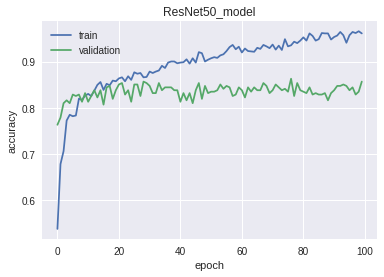

In [35]:
plot_history(hist=hist_3, title='ResNet50_model')

In [36]:
model = model_ResNet50(inp=X_train_res)
model.load_weights('./weights/ResNet50_model_weights.hdf5')
model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
model_ResNet50_score = model.evaluate(X_val_res, y_val_res, verbose=0)
print("The {} accuracy is: {:.3f}".format('ResNet50_model', model_ResNet50_score[1]))

acc['ResNet50_model'] = model_ResNet50_score


The ResNet50_model accuracy is: 0.863


## Conclusion:

Three different models (e.g. benchmark, model_1, and ResNet50_model) were tested in this project. The model_1  accuracy was higher than the benchmark and ResNet50_model accuracies as shown in the following figure, so at this stage the model_1 is selected as the best model.

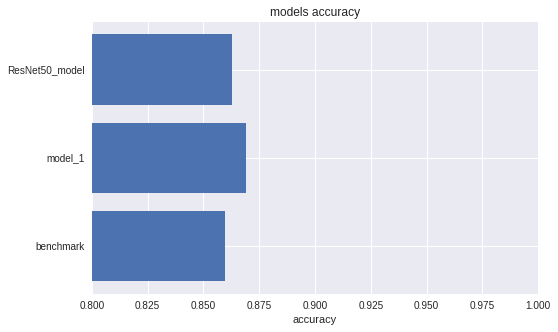

The highest accuracy is 0.869


In [37]:
fig = plt.figure(figsize=(8,5))

models = list(acc.keys())
scores = [acc[m][1] for m in models]
y_pos = np.arange(len(models))
plt.barh(y_pos, scores)
plt.yticks(y_pos, models)
plt.xlabel('accuracy')
plt.xlim([0.8,1])
plt.title('models accuracy')
plt.show()

print('The highest accuracy is {:.3f}'.format(max(scores)))